In [1]:
from osgeo import gdal
gdal.UseExceptions()

ds: gdal.Dataset = gdal.Open("./mola_data.tif")

In [20]:
band: gdal.Band = ds.GetRasterBand(1)
print(f"Raster size: {band.XSize} x {band.YSize}")

minimum, maximum, mean, stddev = band.GetStatistics(True, True)

print(f"Min: {minimum}, Max: {maximum}, Mean: {mean}, StdDev: {stddev}")

Raster size: 46080 x 23040
Min: -8061.0, Max: 20737.0, Mean: -726.00892466065, StdDev: 2970.7799910895


In [46]:
import typing
import struct

def read_horizontal_scanline(x_offset: int, y_offset: int, width: int) -> tuple[float]:
    scanline = band.ReadRaster(
        xoff=x_offset,
        yoff=y_offset,
        xsize=width,
        ysize=1,
        buf_xsize=width,
        buf_ysize=1,
        buf_type=gdal.GDT_Float32
    )

    return typing.cast(tuple[float], struct.unpack('f' * width, scanline))


For example, let's try to chart the elevation of a line through Olympus Mons:

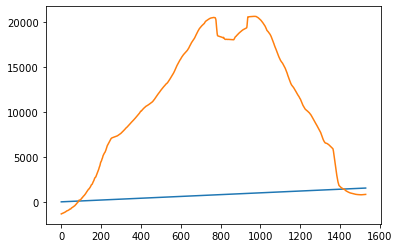

In [44]:
from matplotlib import pyplot as plt

start_x = 5135
end_x = 6665
start_y = 9188  # Approximately the middle of the mountain in terms of North/South

line = read_horizontal_scanline(start_x, start_y, end_x - start_x)

plt.plot(line)

Here is a top-down satellite image of the same volcano:
![olympus_mons.png](olympus_mons.png)

Let's do the same for all our known_features.

In [5]:
IMAGE_HEIGHT = 23040
IMAGE_WIDTH = 46080

def coord_to_x_y(lat: float, long: float) -> tuple[float, float]:
    """
    :param lat: -90 to 90
    :param long: -180 to 180
    :return: x, y pixel coordinates from the tiff image
    """
    x = ((long + 180) / 360) * IMAGE_WIDTH
    y = ((-lat + 90) / 180) * IMAGE_HEIGHT

    return round(x), round(y)

coord_to_x_y(18.68, -133.8)

(5914, 9129)

In [38]:
def get_scanlines_to_read(start_x: int, end_x: int, start_y: int, end_y: int) -> list[tuple[int, tuple[int, int]]]:
    slope = (end_x - start_x) / (end_y - start_y + 1)  # For every y, how many x's do we change
    x_size = round(slope) + 1

    result = []

    for y in range(start_y, end_y + 1):
        first_x = round(slope * (y - start_y)) + start_x
        last_x = first_x + x_size

        result.append((y, (first_x, last_x)))

    return result

# start_x, start_y = coord_to_x_y(23.68, -139.24)
# end_x, end_y = coord_to_x_y(18.65, -127.8)
# end_x, end_y = coord_to_x_y(23.67, -127.8)
# end_x, end_y = coord_to_x_y(18.65, -139.24)

# print(start_x, start_y)
# print(end_x, end_y)
#
# get_scanlines_to_read(start_x, end_x, start_y, end_y)

5217 8489
6682 9133


[(8489, (5217, 5220)),
 (8490, (5219, 5222)),
 (8491, (5222, 5225)),
 (8492, (5224, 5227)),
 (8493, (5226, 5229)),
 (8494, (5228, 5231)),
 (8495, (5231, 5234)),
 (8496, (5233, 5236)),
 (8497, (5235, 5238)),
 (8498, (5237, 5240)),
 (8499, (5240, 5243)),
 (8500, (5242, 5245)),
 (8501, (5244, 5247)),
 (8502, (5247, 5250)),
 (8503, (5249, 5252)),
 (8504, (5251, 5254)),
 (8505, (5253, 5256)),
 (8506, (5256, 5259)),
 (8507, (5258, 5261)),
 (8508, (5260, 5263)),
 (8509, (5262, 5265)),
 (8510, (5265, 5268)),
 (8511, (5267, 5270)),
 (8512, (5269, 5272)),
 (8513, (5272, 5275)),
 (8514, (5274, 5277)),
 (8515, (5276, 5279)),
 (8516, (5278, 5281)),
 (8517, (5281, 5284)),
 (8518, (5283, 5286)),
 (8519, (5285, 5288)),
 (8520, (5287, 5290)),
 (8521, (5290, 5293)),
 (8522, (5292, 5295)),
 (8523, (5294, 5297)),
 (8524, (5296, 5299)),
 (8525, (5299, 5302)),
 (8526, (5301, 5304)),
 (8527, (5303, 5306)),
 (8528, (5306, 5309)),
 (8529, (5308, 5311)),
 (8530, (5310, 5313)),
 (8531, (5312, 5315)),
 (8532, (53

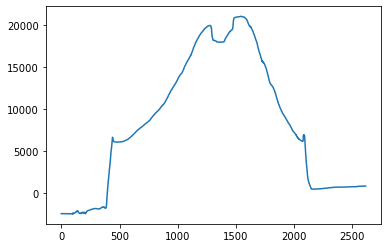

In [59]:
def read_line(start_x: int, start_y: int, end_x: int, end_y: int) -> list[float]:
    lines = get_scanlines_to_read(start_x, end_x, start_y, end_y)

    result = []

    for line in lines:
        y = line[0]
        x = line[1]
        result += read_horizontal_scanline(x[0], y, x[1] - x[0])

    return result

start_x, start_y = coord_to_x_y(23.68, -139.24)
end_x, end_y = coord_to_x_y(13.48, -127.8)

line = read_line(start_x, start_y, end_x, end_y)

plt.plot(line)

In [ ]:
def normalize(line: tuple[float]) -> list[tuple[float, float]]:
    length = len(line)

    min_height = min(line)
    max_height = max(line)

    height_diff = max_height - min_height

    return [(i/length, (line[i] - min_height) / height_diff) for i in range(length)]

normalized = normalize(line)

xs, ys = zip(*normalized)

plt.plot(xs, ys)

In [78]:
import xml.etree.ElementTree as ET

tree = ET.parse("mars_features.xml")
root = tree.getroot()

features = []

for child in root:
    print(dict(child))

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{